# AIPI 590 - XAI | Assignment #05
### Description
Utilize SHAP on the local explanations from a pretrained ResNet34 blackbox model.
### Your Name
Xinyue(Yancey) Yang

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Talos6/AIPI590-SHAP/blob/main/AIPI590-SHAP.ipynb)

In [7]:
# Load packages
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Install shape if not already installed
!pip install shap==0.45.1

import shap

In [2]:
# Connect your GitHub repository to your Google Colab notebook

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590-SHAP"
git_path = 'https://github.com/Talos6/AIPI590-SHAP.git'
!git clone "{git_path}"

# Change working directory to location of notebook
%cd "{repo_name}"
%ls

Cloning into 'AIPI590-SHAP'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 641.69 KiB | 4.42 MiB/s, done.
/content/AIPI590-SHAP
dog_children_ball.png  README.md


## Sample Data
I am using a sample image from web. Saved in repo and it consist of a child playing basketball with a dog.


In [3]:
# Load the image
img = Image.open('./dog_children_ball.png').convert('RGB')

## SHAP
SHAP is an explanation tool based on Shapley values from cooperative game theory. It provides explanation by distributiong the prediction's impact fairly among all input features. For image classification problem, it highlights parts of the image that contribute positively (red) or negatively (blue) to the model prediction.

### ResNet34 Model
A preTrained ResNet34 model will be used for image classification, it is a blackbox model and it will be explained later on by the SHAP.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[522]], device='cuda:0')
(1, 224, 224, 3)
(1, 3, 224, 224, 1)
(1, 224, 224, 3)


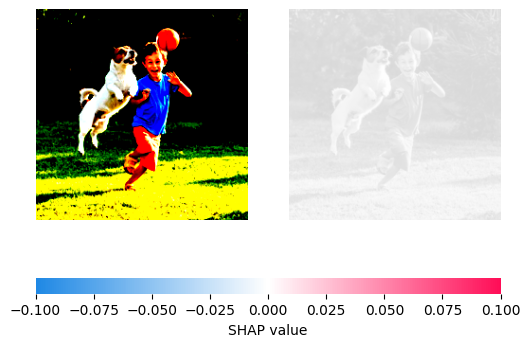

In [76]:
# load a pre-trained ResNet34 model
model = models.resnet34(pretrained=True)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# define the image preprocessing function
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# preprocess the image
img_tensor = preprocess(img).unsqueeze(0).to(device)

# prepare a background dataset
background = img_tensor.repeat(10, 1, 1, 1)

# initialize the Explainer
explainer = shap.GradientExplainer(model, background)

# compute SHAP values
shap_values, indexes = explainer.shap_values(img_tensor, ranked_outputs=1)

# convert data to shap image
img_np = img_tensor.cpu().numpy().transpose((0, 2, 3, 1))
shap_values_np = shap_values[..., 0].transpose((0, 2, 3, 1))

# check data format
print(indexes)
print(img_np.shape)
print(shap_values.shape)
print(shap_values_np.shape)

# Visualize the SHAP explanation
shap.image_plot(shap_values_np, img_np)

## Explanation
The visualization above is the shap values for the top predicted class for the given test image. As we can see, no single pixel contributed positively or negatively to the final prediction. It might because the SHAP values is very small that is visualize insiginificant or the feature importance is spread across pixels that for ResNet model it aggregate input pixels into convolutional feature so resulting in uniform SHAP values.  

## Discussion

SHAP has an absolute advantage on it reveals the relationship between input and prediction, by visualizing the explanation, we would clearly see each feature is positively or negatively contributed to the prediction. By doing so, we would have a better understanding of the black-box model behavior and monitor the feature importance. SHAP also provides local explanations to a specific prediction, which is useful for understanding individual cases rather than just model wise trends. SHAP can be applied to any model and give an foundamental implication on input and output.

For large or complex model, SHAP is very computationally expensive as it calculates contribution for each feature for each prediction. And for what we saw above, it also hard to interpret deep network model's features without proper aggregation techniques.

Consider improvements, I would like to pursue a model-specific SHAP approach like DeepSHAP or using DeepExplainer for complex netwrok, it will help reduce the computation time while maintaining explanation quality. I also what to seek proper aggregation techniques for SHAP to interpret feature contribution and generate a more understandable explanation.